# 1. Feature Engineering
We start off by importing useful libraries, the *application_train* and *application_test* datasets. We check basic facts such as the amount of NaN values, number of categories by categorical features.

In [1]:
import numpy as np, pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')
print(train.shape)
train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
train["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [4]:
print("Columns with NaN values: " + str((train.isnull().sum()!=0).sum()))

Columns with NaN values: 67


In [5]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [6]:
train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

LabelEncoding categorical features with at most 2 unique values.
WARNING: EMERGENCYSTATE_MODE has 3 unique values, NaN is not included in the above list.

## 1.1 Label Encoding and Dummy Variables

We encode binary categorical features with values 0,1. Features with multiple categories are handled with dummy variables.

In [7]:
lab_enc = LabelEncoder()

for col in train:
    if train[col].dtype == 'object':
        if len(list(train[col].unique())) <= 2:
            lab_enc.fit(train[col])
            train[col] = lab_enc.transform(train[col])
            test[col] = lab_enc.transform(test[col])

In [8]:
print("Train shape before: " + str(train.shape))
print("Test shape before: " + str(test.shape))

train = pd.get_dummies(train)
test = pd.get_dummies(test)

print("Train shape after: " + str(train.shape))
print("Test shape after: " + str(test.shape))

Train shape before: (307511, 122)
Test shape before: (48744, 121)
Train shape after: (307511, 243)
Test shape after: (48744, 239)


We align columns of train and test set

In [9]:
train_y = train["TARGET"]

train, test = train.align(test, join = "inner", axis = 1)

train["TARGET"] = train_y

print("Train shape: " + str(train.shape))
print("Test shape: " + str(test.shape))

Train shape: (307511, 240)
Test shape: (48744, 239)


## 1.2 DAYS_EMPLOYED anomalies
We find anomalies in both the train and test datasets:

The only such number is 365243. We create a column to mark the anomaly and we replace the values with np.nan. 

In [10]:
train["DAYS_EMPLOYED"].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [11]:
train[train["DAYS_EMPLOYED"]<365243]['DAYS_EMPLOYED'].sort_values()

280994   -17912
273069   -17583
208899   -17546
35191    -17531
234168   -17522
          ...  
161893       -2
111965       -2
246105       -1
23691         0
121625        0
Name: DAYS_EMPLOYED, Length: 252137, dtype: int64

In [12]:
anomalies = train[train['DAYS_EMPLOYED'] == 365243]
non_anomalies = train[train['DAYS_EMPLOYED'] != 365243]

print("Default rate of anomalies: {0:.2f}%".format(100*anomalies["TARGET"].mean()))
print("Default rate of non-anomalies: {0:.2f}%".format(100*non_anomalies["TARGET"].mean()))

Default rate of anomalies: 5.40%
Default rate of non-anomalies: 8.66%


<AxesSubplot:ylabel='Frequency'>

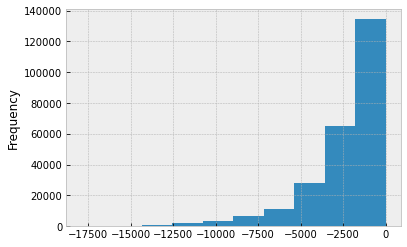

In [13]:
train['DAYS_EMPLOYED_ANOM'] = train['DAYS_EMPLOYED'] == 365243
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
train["DAYS_EMPLOYED"].plot.hist()

In [14]:
test['DAYS_EMPLOYED_ANOM'] = test['DAYS_EMPLOYED'] == 365243
test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
print('Total anomalies: ' + str(test['DAYS_EMPLOYED_ANOM'].sum()))

Total anomalies: 9274


## 1.3 Binning Age Feature
The DAYS_BIRTH data is in a very weird format = -(days since birth). We ignore the minus and bin the ages in 5 year intervals. Luckily the data given seems very normal and realistic - no outliers.

In [16]:
train['DAYS_BIRTH'] = -train['DAYS_BIRTH']

In [17]:
age_data = train[["TARGET", "DAYS_BIRTH"]]
age_data.loc[:, 'YEARS'] = age_data['DAYS_BIRTH'] / 365

age_data.loc[:, 'YEARS_BINNED'] = pd.cut(age_data['YEARS'], bins = np.linspace(20, 70, num = 11))
age_data

C:\Users\csaba\AppData\Local\Temp\ipykernel_12032\2017075975.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data.loc[:, 'YEARS'] = age_data['DAYS_BIRTH'] / 365
C:\Users\csaba\AppData\Local\Temp\ipykernel_12032\2017075975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data.loc[:, 'YEARS_BINNED'] = pd.cut(age_data['YEARS'], bins = np.linspace(20, 70, num = 11))


,TARGET,DAYS_BIRTH,YEARS,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
...,...,...,...,...
307506,0,9327,25.553425,"(25.0, 30.0]"
307507,0,20775,56.917808,"(55.0, 60.0]"
307508,0,14966,41.002740,"(40.0, 45.0]"
307509,1,11961,32.769863,"(30.0, 35.0]"


In [18]:
age_groups = age_data.groupby('YEARS_BINNED').mean()

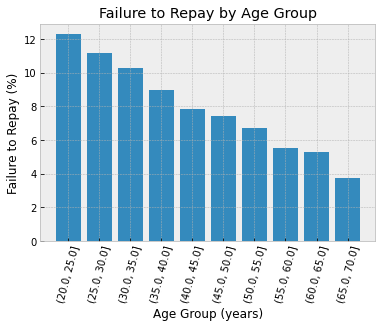

In [19]:
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET']);
plt.xticks(rotation=75);
plt.xlabel('Age Group (years)');
plt.ylabel('Failure to Repay (%)');
plt.title('Failure to Repay by Age Group');

## 1.4 List of Strongest Correlations
The basic motivation to check for some correlations. EXT_SOURCE_X variables seem to be features that were engineered from other features. They are also the strongest by far.

In [15]:
correlations = train.corr()["TARGET"].sort_values()

print('Most positive corelations: \n', correlations.tail(15))
print('Most negative corelations: \n', correlations.head(15))

Most positive corelations: 
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64
Most negativ

## 1.4.1 PolynomialFeatures on Strongeset Correlations
We create polynomial features from the most important features from the above list. We can't yet tell if they will be useful. Only creating models can give us that answer.

In [20]:
poly_features = train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]

poly_features_test = test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]

imputer = SimpleImputer(strategy = 'median')
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

In [21]:
poly_transformer = PolynomialFeatures(degree = 3)
poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

In [22]:
names = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])
poly_features = pd.DataFrame(poly_features, columns = names)
poly_features_test = pd.DataFrame(poly_features_test, columns = names)
poly_features['TARGET'] = train['TARGET']
poly_features.corr()['TARGET'].sort_values()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH     -0.155891
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH     -0.151816
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
EXT_SOURCE_3 DAYS_BIRTH                  -0.150109
EXT_SOURCE_2^2                           -0.149512
EXT_SOURCE_2^2 DAYS_BIRTH                -0.149313
EXT_SOURCE_3^2 DAYS_BIRTH                -0.141777
EXT_SOURCE_3^2                           -0.141662
EXT_SOURCE_2^3                 

In [23]:
poly_features["SK_ID_CURR"] = train["SK_ID_CURR"]
poly_features_test["SK_ID_CURR"] = test["SK_ID_CURR"]

train_poly = train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')
test_poly = test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

train_poly, test_poly = train_poly.align(test_poly, join = 'inner', axis = 1)

#### Creating Features

In [24]:
train_domain = train.copy()
test_domain = test.copy()

train_domain['CREDIT_INCOME_PERCENT'] = train_domain['AMT_CREDIT'] / train_domain['AMT_INCOME_TOTAL']
train_domain['ANNUITY_INCOME_PERCENT'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_INCOME_TOTAL']
train_domain['CREDIT_TERM'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_CREDIT']
train_domain['DAYS_EMPLOYED_PERCENT'] = train_domain['DAYS_EMPLOYED'] / train_domain['DAYS_BIRTH']

test_domain['CREDIT_INCOME_PERCENT'] = test_domain['AMT_CREDIT'] / test_domain['AMT_INCOME_TOTAL']
test_domain['ANNUITY_INCOME_PERCENT'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_INCOME_TOTAL']
test_domain['CREDIT_TERM'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_CREDIT']
test_domain['DAYS_EMPLOYED_PERCENT'] = test_domain['DAYS_EMPLOYED'] / test_domain['DAYS_BIRTH']

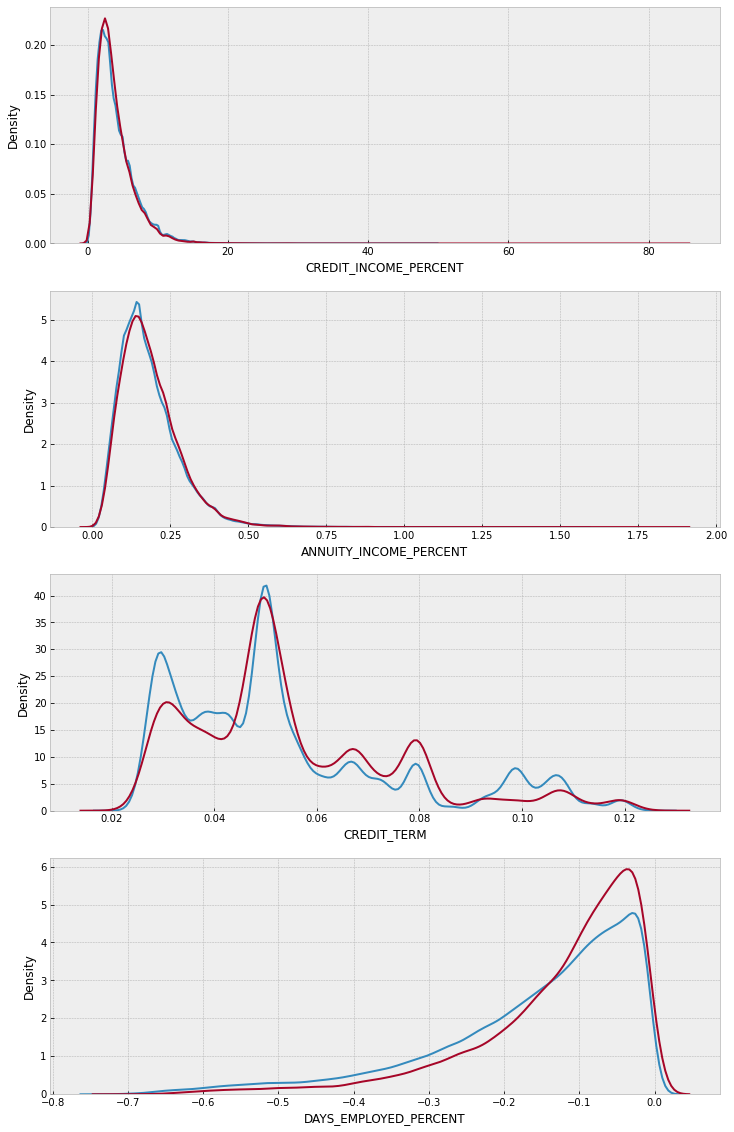

In [25]:
plt.figure(figsize=(12,20))
l = ['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']

for i, feature in enumerate(l):
    plt.subplot(len(l), 1, i+1)
    
    sns.kdeplot(train_domain.loc[train_domain['TARGET']==0, feature], label = 'target == 0')
    sns.kdeplot(train_domain.loc[train_domain['TARGET']==1, feature], label = 'target == 1')
    plt.xlabel(feature)

# 2. Functions for Aggregation

## 2.1 Numerical Columns
We choose our numerical columns, group them up by IDs and calculate group means, maxes, mins and counts.

In [27]:
def agg_numeric(df, group_var, df_name):
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    
    columns = [group_var]
    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name,var, stat))
    agg.columns = columns
    
    return agg

## 2.2 Categorical Columns
We create dummies of categorical features, group them up by IDs and assign the sums and means of the groups.

In [28]:
def count_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object'))
    
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    for var in categorical.columns.levels[0]:
        for stat in ['count', 'count_norm']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
            
    categorical.columns = column_names
    
    return categorical

## 2.3 TARGET == 0/1 Kernel Density Estimation
We will be frequently plotting and searching for features that are correlated with the TARGET variable

In [26]:
def kde_target(var_name, df):
    corr = df['TARGET'].corr(df[var_name])
    
    plt.figure(figsize = (12, 6))
    
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    plt.legend()
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))

# 3. Feature Engineering - bureau
We aggregate categorical and numerical features and merge it to the train and test datasets. 

In [29]:
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')

In [30]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), 'SK_ID_CURR', 'bureau')
bureau_balance_counts = count_categorical(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')
bureau_balance_agg = agg_numeric(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')

bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), 'SK_ID_CURR', 'client')

for dataset in [bureau_counts, bureau_agg, bureau_balance_by_client]:
    train = train.merge(dataset, on ='SK_ID_CURR', how = 'left')

In [31]:
train.shape

(307511, 452)

In [32]:
mis_val = train.isna().sum()[train.isna().sum()!=0]
mis_val_perc = 100 * mis_val / len(train)
mis_val_table = pd.concat([mis_val, mis_val_perc], axis = 1)


mis_val_table = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table.sort_values(by = 'Missing Values', ascending = False)

,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,73.981744
bureau_AMT_ANNUITY_max,227502,73.981744
bureau_AMT_ANNUITY_mean,227502,73.981744
client_bureau_balance_STATUS_4_count_mean,215280,70.007252
client_bureau_balance_STATUS_3_count_max,215280,70.007252
...,...,...
EXT_SOURCE_2,660,0.214626
AMT_GOODS_PRICE,278,0.090403
AMT_ANNUITY,12,0.003902
CNT_FAM_MEMBERS,2,0.000650


In [33]:
test = test.merge(bureau_counts, on='SK_ID_CURR', how = 'left')
test = test.merge(bureau_agg, on='SK_ID_CURR', how = 'left')
test = test.merge(bureau_balance_by_client, on='SK_ID_CURR', how = 'left')

In [34]:
train_labels = train['TARGET']

train, test = train.align(test, join = 'inner', axis = 1)
train['TARGET'] = train_labels

In [37]:
train.to_csv('train_1.csv', index = False)
test.to_csv('test_1.csv', index = False)

In [38]:
## Correlations

corrs = train.corr()
corrs = corrs.sort_values('TARGET', ascending = False)
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
DAYS_EMPLOYED,0.074958
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [39]:
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
NAME_EDUCATION_TYPE_Higher education,-0.056593
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
DAYS_BIRTH,-0.078239
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


Below we find a function for removing features with the amount of missing values above a certain threshold.

In [41]:
threshold = 0.8

above_threshold_vars = {}

for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] >threshold])

In [43]:
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
                
                
cols_to_remove = list(set(cols_to_remove))
print(len(cols_to_remove))

137
